Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

Cell (0, 0): (empty or invalid)
Cell (0, 1): (empty or invalid)
Cell (0, 2): 1
Cell (0, 3): 8
Cell (0, 4): 9
Cell (0, 5): 2
Cell (0, 6): 6
Cell (0, 7): (empty or invalid)
Cell (0, 8): (empty or invalid)
Cell (1, 0): (empty or invalid)
Cell (1, 1): 9
Cell (1, 2): 0
Cell (1, 3): 0
Cell (1, 4): (empty or invalid)
Cell (1, 5): (empty or invalid)
Cell (1, 6): (empty or invalid)
Cell (1, 7): 2
Cell (1, 8): 2
Cell (2, 0): 0
Cell (2, 1): 5
Cell (2, 2): 0
Cell (2, 3): 0
Cell (2, 4): (empty or invalid)
Cell (2, 5): (empty or invalid)
Cell (2, 6): 0
Cell (2, 7): (empty or invalid)
Cell (2, 8): (empty or invalid)
Cell (3, 0): (empty or invalid)
Cell (3, 1): 8
Cell (3, 2): 4
Cell (3, 3): (empty or invalid)
Cell (3, 4): 0
Cell (3, 5): (empty or invalid)
Cell (3, 6): (empty or invalid)
Cell (3, 7): (empty or invalid)
Cell (3, 8): (empty or invalid)
Cell (4, 0): (empty or invalid)
Cell (4, 1): (empty or invalid)
Cell (4, 2): 3
Cell (4, 3): 5
Cell (4, 4): 4
Cell (4, 5): 7
Cell (4, 6): 9
Cell (4, 7): (e

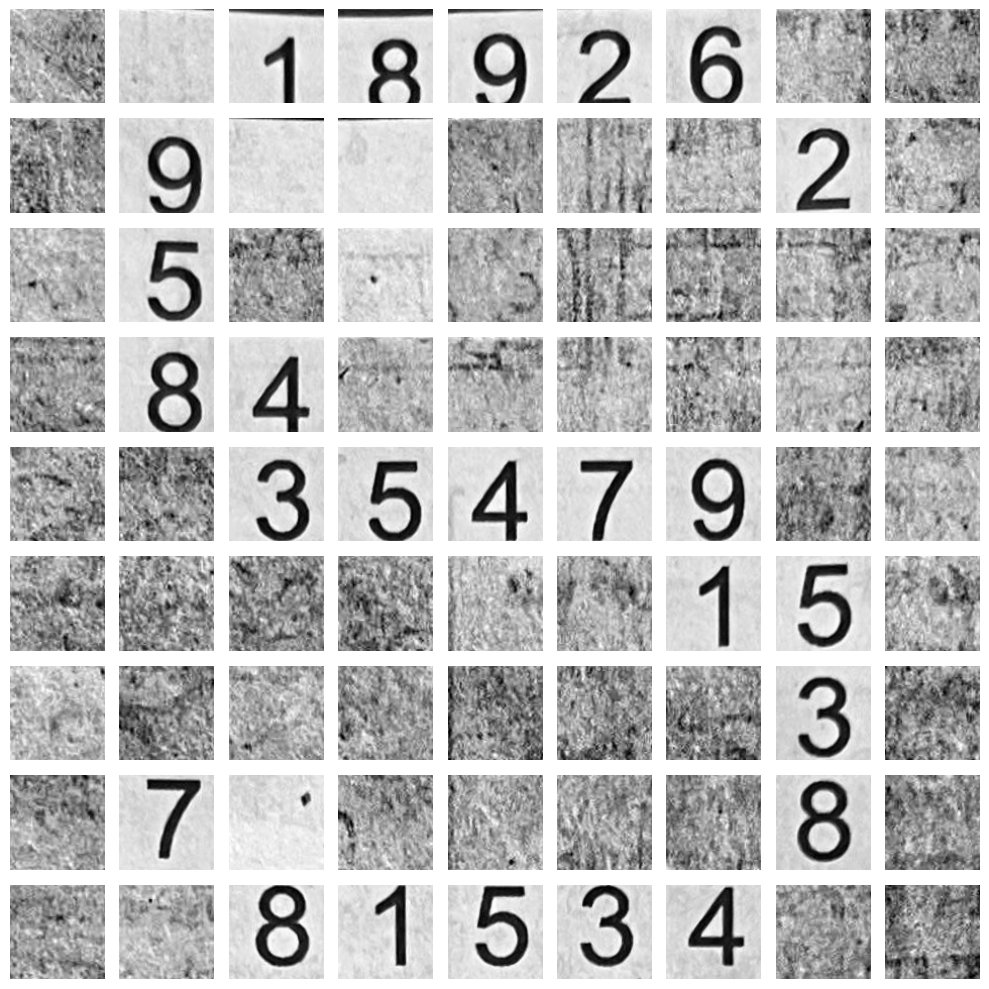

In [2]:
from transformers import pipeline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re

# Path to your local folder where the model is stored
model_path = "microsoft/trocr-base-handwritten"  # Adjust the path if necessary

# Use the model from the local folder with PyTorch
pipe = pipeline("image-to-text", model=model_path, framework="pt")

# Load the image
img = cv2.imread('sudoku.jpg', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur
proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

# Apply adaptive thresholding
proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Invert the image to make grid lines white
proc = cv2.bitwise_not(proc, proc)

# Dilate the image to enhance grid lines
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
proc = cv2.dilate(proc, kernel)

# Find contours in the image
contours, _ = cv2.findContours(proc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and select the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)
polygon = contours[0]

# Function to calculate the distance between two points
def distance_between(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Find the four extreme points of the contour
bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=lambda x: x[1])
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=lambda x: x[1])
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=lambda x: x[1])
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=lambda x: x[1])

# Extract the four corners
crop_rect = [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

# Calculate the side length of the square
side = max([
    distance_between(crop_rect[0], crop_rect[1]),
    distance_between(crop_rect[1], crop_rect[2]),
    distance_between(crop_rect[2], crop_rect[3]),
    distance_between(crop_rect[3], crop_rect[0])
])

# Define the destination points for the perspective transform
dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

# Perform the perspective transform
m = cv2.getPerspectiveTransform(np.array(crop_rect, dtype='float32'), dst)
warped = cv2.warpPerspective(img, m, (int(side), int(side)))

# Infer the 81 cell grid
squares = []
side = warped.shape[0] // 9
for j in range(9):
    row = []
    for i in range(9):
        p1 = (i * side, j * side)  # Top-left corner of the cell
        p2 = ((i + 1) * side, (j + 1) * side)  # Bottom-right corner of the cell
        row.append((p1, p2))
    squares.append(row)

# Create subplot grid
fig, axs = plt.subplots(9, 9, figsize=(10, 10))

# Extract and display cropped cells
for row_idx, row in enumerate(squares):
    for col_idx, square in enumerate(row):
        p1, p2 = square
        # Extract the cell
        cell = warped[int(p1[1]):int(p2[1]), int(p1[0]):int(p2[0])]
        
        # Crop borders (adjust the margin as needed)
        margin = int(cell.shape[0] * 0.15)  # 15% margin
        cell = cell[margin:-margin, margin:-margin]
        
        # Display the cropped cell
        axs[row_idx, col_idx].imshow(cell, cmap='gray')
        axs[row_idx, col_idx].axis('off')
        
        # Save the cell image temporarily to pass it to the pipeline
        cell_path = f"cell_{row_idx}_{col_idx}.png"
        cv2.imwrite(cell_path, cell)
        
        # Use the pipeline to recognize text from the cell image
        result = pipe(cell_path)
        recognized_text = result[0]['generated_text']
        
        # Check if the recognized text is a single-digit number
        if re.match(r'^\d$', recognized_text):
            print(f"Cell ({row_idx}, {col_idx}): {recognized_text}")
        else:
            print(f"Cell ({row_idx}, {col_idx}): (empty or invalid)")

plt.tight_layout()
plt.show()

In [7]:
from transformers import pipeline
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re

# Path to the local directory where the model is saved
save_directory = "./trocr_model"

# Load the model, feature extractor, and tokenizer from the local directory
model = VisionEncoderDecoderModel.from_pretrained(save_directory)
feature_extractor = ViTFeatureExtractor.from_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(save_directory)

# Create the pipeline using the locally loaded model, feature extractor, and tokenizer
pipe = pipeline(
    "image-to-text",
    model=model,
    feature_extractor=feature_extractor,
    tokenizer=tokenizer,
    framework="pt"
)

# Load the image
img = cv2.imread('sudoku.jpg', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur
proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

# Apply adaptive thresholding
proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Invert the image to make grid lines white
proc = cv2.bitwise_not(proc, proc)

# Dilate the image to enhance grid lines
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
proc = cv2.dilate(proc, kernel)

# Find contours in the image
contours, _ = cv2.findContours(proc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and select the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)
polygon = contours[0]

# Function to calculate the distance between two points
def distance_between(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Find the four extreme points of the contour
bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=lambda x: x[1])
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=lambda x: x[1])
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=lambda x: x[1])
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=lambda x: x[1])

# Extract the four corners
crop_rect = [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

# Calculate the side length of the square
side = max([
    distance_between(crop_rect[0], crop_rect[1]),
    distance_between(crop_rect[1], crop_rect[2]),
    distance_between(crop_rect[2], crop_rect[3]),
    distance_between(crop_rect[3], crop_rect[0])
])

# Define the destination points for the perspective transform
dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

# Perform the perspective transform
m = cv2.getPerspectiveTransform(np.array(crop_rect, dtype='float32'), dst)
warped = cv2.warpPerspective(img, m, (int(side), int(side)))

# Infer the 81 cell grid
squares = []
side = warped.shape[0] // 9
for j in range(9):
    row = []
    for i in range(9):
        p1 = (i * side, j * side)  # Top-left corner of the cell
        p2 = ((i + 1) * side, (j + 1) * side)  # Bottom-right corner of the cell
        row.append((p1, p2))
    squares.append(row)

# Create a 9x9 grid to store the Sudoku puzzle
sudoku_grid = [[0 for _ in range(9)] for _ in range(9)]

# Extract and display cropped cells
for row_idx, row in enumerate(squares):
    for col_idx, square in enumerate(row):
        p1, p2 = square
        # Extract the cell
        cell = warped[int(p1[1]):int(p2[1]), int(p1[0]):int(p2[0])]
        
        # Crop borders (adjust the margin as needed)
        margin = int(cell.shape[0] * 0.15)  # 15% margin
        cell = cell[margin:-margin, margin:-margin]
        
        # Save the cell image temporarily to pass it to the pipeline
        cell_path = f"cell_{row_idx}_{col_idx}.png"
        cv2.imwrite(cell_path, cell)
        
        # Use the pipeline to recognize text from the cell image
        result = pipe(cell_path)
        recognized_text = result[0]['generated_text']
        
        # Check if the recognized text is a single-digit number
        if re.match(r'^\d$', recognized_text):
            sudoku_grid[row_idx][col_idx] = int(recognized_text)
        else:
            sudoku_grid[row_idx][col_idx] = 0  # Fill with 0 for invalid entries

# Print the Sudoku grid
print("Sudoku Grid:")
for row in sudoku_grid:
    print(row)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

Sudoku Grid:
[0, 0, 1, 8, 9, 2, 6, 0, 0]
[0, 9, 0, 0, 0, 0, 0, 2, 2]
[0, 5, 0, 0, 0, 0, 0, 0, 0]
[0, 8, 4, 0, 0, 0, 0, 0, 0]
[0, 0, 3, 5, 4, 7, 9, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 5, 0]
[0, 0, 0, 0, 0, 0, 0, 3, 0]
[0, 7, 0, 0, 0, 0, 0, 8, 0]
[0, 2, 8, 1, 5, 3, 4, 0, 0]


In [8]:
from transformers import pipeline
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re

# Path to the local directory where the model is saved
save_directory = "./trocr_model"

# Load the model, feature extractor, and tokenizer from the local directory
model = VisionEncoderDecoderModel.from_pretrained(save_directory)
feature_extractor = ViTFeatureExtractor.from_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(save_directory)

# Create the pipeline using the locally loaded model, feature extractor, and tokenizer
pipe = pipeline(
    "image-to-text",
    model=model,
    feature_extractor=feature_extractor,
    tokenizer=tokenizer,
    framework="pt"
)

# Load the image
img = cv2.imread('sudoku.jpg', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur
proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

# Apply adaptive thresholding
proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Invert the image to make grid lines white
proc = cv2.bitwise_not(proc, proc)

# Dilate the image to enhance grid lines
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
proc = cv2.dilate(proc, kernel)

# Find contours in the image
contours, _ = cv2.findContours(proc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and select the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)
polygon = contours[0]

# Function to calculate the distance between two points
def distance_between(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Find the four extreme points of the contour
bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=lambda x: x[1])
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=lambda x: x[1])
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=lambda x: x[1])
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=lambda x: x[1])

# Extract the four corners
crop_rect = [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

# Calculate the side length of the square
side = max([
    distance_between(crop_rect[0], crop_rect[1]),
    distance_between(crop_rect[1], crop_rect[2]),
    distance_between(crop_rect[2], crop_rect[3]),
    distance_between(crop_rect[3], crop_rect[0])
])

# Define the destination points for the perspective transform
dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

# Perform the perspective transform
m = cv2.getPerspectiveTransform(np.array(crop_rect, dtype='float32'), dst)
warped = cv2.warpPerspective(img, m, (int(side), int(side)))

# Infer the 81 cell grid
squares = []
side = warped.shape[0] // 9
for j in range(9):
    row = []
    for i in range(9):
        p1 = (i * side, j * side)  # Top-left corner of the cell
        p2 = ((i + 1) * side, (j + 1) * side)  # Bottom-right corner of the cell
        row.append((p1, p2))
    squares.append(row)

# Create a 9x9 grid to store the Sudoku puzzle
sudoku_grid = [[0 for _ in range(9)] for _ in range(9)]

# Threshold for detecting blank cells (adjust as needed)
blank_threshold = 10  # Standard deviation threshold

# Extract and display cropped cells
for row_idx, row in enumerate(squares):
    for col_idx, square in enumerate(row):
        p1, p2 = square
        # Extract the cell
        cell = warped[int(p1[1]):int(p2[1]), int(p1[0]):int(p2[0])]
        
        # Crop borders (adjust the margin as needed)
        margin = int(cell.shape[0] * 0.15)  # 15% margin
        cell = cell[margin:-margin, margin:-margin]
        
        # Check if the cell is blank
        if np.std(cell) < blank_threshold:
            sudoku_grid[row_idx][col_idx] = 0  # Mark as blank
            continue  # Skip TrOCR prediction for blank cells
        
        # Save the cell image temporarily to pass it to the pipeline
        cell_path = f"cell_{row_idx}_{col_idx}.png"
        cv2.imwrite(cell_path, cell)
        
        # Use the pipeline to recognize text from the cell image
        result = pipe(cell_path)
        recognized_text = result[0]['generated_text']
        
        # Check if the recognized text is a single-digit number
        if re.match(r'^\d$', recognized_text):
            sudoku_grid[row_idx][col_idx] = int(recognized_text)
        else:
            sudoku_grid[row_idx][col_idx] = 0  # Fill with 0 for invalid entries

# Print the Sudoku grid
print("Sudoku Grid:")
for row in sudoku_grid:
    print(row)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

Sudoku Grid:
[0, 0, 1, 8, 9, 2, 6, 0, 0]
[0, 9, 0, 0, 0, 0, 0, 2, 0]
[0, 5, 0, 0, 0, 0, 0, 0, 0]
[0, 8, 4, 0, 0, 0, 0, 0, 0]
[0, 0, 3, 5, 4, 7, 9, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 5, 0]
[0, 0, 0, 0, 0, 0, 0, 3, 0]
[0, 7, 0, 0, 0, 0, 0, 8, 0]
[0, 0, 8, 1, 5, 3, 4, 0, 0]
